In [1]:
!pip install equiflow


In [1]:
import pandas as pd
from tableone import TableOne
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
)
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
import pydata_google_auth
import seaborn as sns
import pandas_gbq
from equiflow import EquiFlow

warnings.filterwarnings("ignore")


/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np

In [2]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [3]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis', 'icd_codes']:
    with open('eicu_1/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from icd_codes"
project = 'capacheiv'

df_o = pd.read_gbq(query, dialect='standard', project_id=project)

In [4]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis', 'icd_codes']:
    with open('eicu_2/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

df_n = pd.read_gbq(query, dialect='standard', project_id=project)

In [5]:
df_n_no_duplicates = df_n[~df_n['uniquepid'].isin(df_o['uniquepid'])] 

In [6]:
df = pd.concat([df_o, df_n_no_duplicates], axis=0, ignore_index=True)

In [7]:
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           '': 'Other/Unknown/Missing',
                                           'Native American':'Indigenous/Native',
                                           'Other/Unknown':'Other/Unknown/Missing'})
df['age_num'] = df['age_num'].astype(float)
df['ApacheScore'] = df['ApacheScore'].astype(float)
df['daysonvent'] = df['daysonvent'].astype(float)


df['gender'] = df['gender'].replace({ '': 'Unknown'})
df = df.fillna({'ethnicity':'Other/Unknown/Missing', 'gender':'Unknown'})
df = df.rename(columns = {'has_sepsis':'Sepsis', 'HOSP_NUM':'Number_of_Admissions', 'hospitaldischargeyear':'Discharge_Year',
                          'age_num':'Age', 'hosp_mortality':'hospital_mortality'})

df['set'] = df['Discharge_Year'].apply(
    lambda x: '2014-2015' if x in [2014, 2015] else(
              '2020-2021' if x in [2020, 2021] else np.nan
    )
)

In [68]:
columns = ['gender', 'Age', 'ethnicity', 'ApacheScore', 'Apache_Version',
           'predicted_hospital_mortality', 'mortality']

categorical = ['gender', 'ethnicity', 'Apache_Version', 'mortality']

table1 = TableOne(data=df,
                  columns=columns,
                  categorical=categorical,
                  groupby='Discharge_Year',  
                  isnull=True)  

table1

Grouped by Discharge_Year                                                                      
                                                                                Missing        Overall          2014          2015          2020         2021
n                                                                                                10257          4020          4001          1384          852
gender, n (%)                           Female                                        0    5008 (48.8)   1989 (49.5)   1951 (48.8)    653 (47.2)   415 (48.7)
                                        Male                                               5247 (51.2)   2030 (50.5)   2049 (51.2)    731 (52.8)   437 (51.3)
                                        Unknown                                                2 (0.0)       1 (0.0)       1 (0.0)                           
Age, mean (SD)                                                                        0    64.9 (17.1)   65.5 (16.6)   65.8 (16.7)   60.9 (18.6)  64.3 (17.9)
ethnicity, n (%)                        African American                              0      996 (9.7)     390 (9.7)     377 (9.4)     135 (9.8)    94 (11.0)
                                        Asian                                                159 (1.6)      72 (1.8)      49 (1.2)      26 (1.9)     12 (1.4)
                                        Caucasian                                          7951 (77.5)   3136 (78.0)   3167 (79.2)   1012 (73.1)   636 (74.6)
                                        Hispanic                                             381 (3.7)     177 (4.4)     167 (4.2)      11 (0.8)     26 (3.1)
                                        Indigenous/Native                                     70 (0.7)      28 (0.7)      25 (0.6)      11 (0.8)      6 (0.7)
                                        Other/Unknown/Missing                                700 (6.8)     217 (5.4)     216 (5.4)    189 (13.7)     78 (9.2)
ApacheScore, mean (SD)                                                                0    66.7 (28.2)   69.7 (28.2)   69.9 (28.7)   55.1 (24.2)  56.5 (24.7)
Apache_Version, n (%)                   IV                                            0  10257 (100.0)  4020 (100.0)  4001 (100.0)  1384 (100.0)  852 (100.0)
predicted_hospital_mortality, mean (SD)                                               0      0.2 (0.2)     0.2 (0.2)     0.2 (0.2)     0.1 (0.1)    0.1 (0.2)
mortality, n (%)                        0                                             0    8328 (81.2)   3268 (81.3)   3188 (79.7)   1186 (85.7)   686 (80.5)
                                        1                                                  1929 (18.8)    752 (18.7)    813 (20.3)    198 (14.3)   166 (19.5)

In [8]:
# Was trying to compare the different diagnosis over the years to include all patients instead of septic 
# patients only, we're not moving forward with that paln for now



# import re
# from sklearn.preprocessing import MultiLabelBinarizer
# from scipy.stats import chi2_contingency


# df['icd9code'] = df['icd9code'].fillna(value='None')

# df['icd9code_split'] = df['icd9code'].str.split(r',\s*')

# df['icd9_major_only'] = df['icd9code_split'].apply(
#     lambda codes: [re.match(r'^(\d+)', code).group(1) for code in codes if re.match(r'^(\d+)', code)]
# )

# mlb = MultiLabelBinarizer()
# icd_code_df = pd.DataFrame(
#     mlb.fit_transform(df['icd9_major_only']),
#     columns=mlb.classes_,
#     index=df.index
# )

# p_values = {}

# for col in icd_code_df:
#     contingency_table = pd.crosstab(df['Discharge_Year'], icd_code_df[col])
    
#     if contingency_table.shape[1] == 2:
#         try:
#             _, p, _, _ = chi2_contingency(contingency_table)
#             p_values[col] = p
#         except ValueError:
#             continue


In [9]:
year_and_diagnosis = pd.concat([df['Discharge_Year'], icd_code_df], axis=1)
df = df.drop(columns=['icd9code_split'])

In [10]:
year_and_diagnosis

,Discharge_Year,003,004,005,008,009,011,017,027,031,...,980,986,989,991,992,995,996,997,998,999
0,2015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390504,2021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390505,2021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390506,2021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390507,2021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
columns = year_and_diagnosis.columns.to_list()
categorical = year_and_diagnosis.columns.to_list()

table = TableOne(year_and_diagnosis, columns=columns, categorical=categorical, groupby='Discharge_Year', pval=True)


In [12]:
EquiFlow._clean_missing = lambda self: None

eqfl = EquiFlow(
    data=df,
    initial_cohort_label='Admitted from 2014-2021',
    categorical=['gender', 'ethnicity', 'Sepsis', 'hospital_mortality']  
)

eqfl.add_exclusion(
    mask=(df.Apache_Version == 'IV'),
    exclusion_reason='Has Apache IV score',
    new_cohort_label=''
)

eqfl.add_exclusion(
    mask=(df.Number_of_Admissions == 1),
    exclusion_reason='Not First Admission',
    new_cohort_label=''
)

eqfl.add_exclusion(
    mask=(df.Sepsis == 1),
    exclusion_reason='Non-Septic Patients',
    new_cohort_label=''
)


eqfl.add_exclusion(
    mask=(df.ApacheScore.notna()),
    exclusion_reason='Missing APACHE Score',
    new_cohort_label=''
)


eqfl.add_exclusion(
    mask=(df.hospital_mortality.notna()),
    exclusion_reason='Missing Mortality Data',
    new_cohort_label=''
)

eqfl.add_exclusion(
    mask=(df.predicted_hospital_mortality >= 0),
    exclusion_reason='Predicted Hopsital\nMortality =-1',
    new_cohort_label=''
)





eqfl.plot_flows()

In [13]:
df = df[df.hospital_mortality.notna()]
df = df[df.ApacheScore.notna()]
df = df[df.Sepsis == 1]
df = df[df.Number_of_Admissions == 1]
df = df[df.predicted_hospital_mortality >= 0]
df = df[df.Apache_Version == 'IV']


In [23]:
df

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,icd9code,hospitaladmityear,hospitaladmittime,hospitaldischargetime,unitadmityear,unitadmittime,unitdischargeyear,unitdischargetime,set,icd9_major_only
124,196405,171819,Female,79,Caucasian,56,82,"Pneumonia, aspiration",152.4,15:59:00,...,"038.9, A41.9,507.0, J69.0,507.0, J69.0,427.31,...",<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,2014-2015,"[038, 507, 507, 427, 427, 401, 401, 038, 038, ..."
128,162575,145444,Male,> 89,Caucasian,56,82,"Infarction, acute myocardial (MI)",180.3,04:51:00,...,"486, J18.9,410.71, I21.4,410.71, I21.4,,,,780....",<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,2014-2015,"[486, 410, 410, 780, 276, 038, 038, 584, 780, ..."
168,201461,175745,Male,65,Caucasian,56,82,Cellulitis and localized soft tissue infection...,182.9,06:38:00,...,"780.57, G47.33,401.9, I10,,728.86, M72.6,038.9...",<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,2014-2015,"[780, 401, 728, 038]"
225,178776,158007,Female,57,Caucasian,56,82,"Sepsis, pulmonary",167.6,00:14:00,...,"486, J18.9,786.50, R07.9,599.0, N39.0,183.0, C...",<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,2014-2015,"[486, 786, 599, 183, 038]"
240,177170,156766,Male,> 89,Caucasian,56,82,"Sepsis, renal/UTI (including bladder)",167.6,04:09:00,...,"038.9, A41.9,,599.0, N39.0,427.31, I48.0,486, ...",<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,2014-2015,"[038, 599, 427, 486]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390238,6834041,5541773,Male,58,African American,212,1780,"Sepsis, pulmonary",180.3,1970-01-01 07:45:00+00:00,...,None,2021,noon,night,2021,night,2021,evening,2020-2021,[]
390267,6802008,5514782,Female,63,Caucasian,212,1780,"Sepsis, renal/UTI (including bladder)",167.6,1970-01-01 10:01:00+00:00,...,None,2021,evening,noon,2021,evening,2021,evening,2020-2021,[]
390268,6806005,5518097,Female,62,Caucasian,212,1780,"Sepsis, renal/UTI (including bladder)",157.5,1970-01-01 17:39:00+00:00,...,None,2021,midnight,evening,2021,midnight,2021,evening,2020-2021,[]
390287,6815212,5525869,Female,58,African American,212,1780,"Sepsis, renal/UTI (including bladder)",175.3,1970-01-01 10:25:00+00:00,...,None,2021,evening,night,2021,night,2021,midday,2020-2021,[]


In [24]:
results = []

for race in df['ethnicity'].unique():
    row = {'ethnicity': race}
    
    for set_val in df['set'].unique():
        subset = df[(df['ethnicity'] == race) & (df['set'] == set_val)]
        
        if subset['mortality'].nunique() == 2:
            try:
                auroc = roc_auc_score(subset['mortality'], subset['predicted_hospital_mortality'])
                row[set_val] = auroc
            except ValueError:
                row[set_val] = None
        else:
            row[set_val] = None
    
    results.append(row)

auroc_df = pd.DataFrame(results)
auroc_df

,ethnicity,2014-2015,2020-2021
0,Caucasian,0.793745,0.740259
1,Hispanic,0.873402,0.772727
2,Other/Unknown/Missing,0.811494,0.654470
3,African American,0.799180,0.789004
4,Asian,0.855812,0.723810
5,Indigenous/Native,0.894231,0.500000


In [25]:
results = []

for race in df['ethnicity'].dropna().unique():
    row = {'ethnicity': race}
    
    for set_val in df['set'].unique():
        subset = df[(df['ethnicity'] == race) & (df['set'] == set_val)]
        
        if len(subset) > 0:
            observed = subset['mortality'].sum()
            expected = subset['predicted_hospital_mortality'].sum()
            smr = observed / expected if expected > 0 else None
            row[set_val] = smr
        else:
            row[set_val] = None
            
    results.append(row)

smr_df = pd.DataFrame(results)
smr_df

,ethnicity,2014-2015,2020-2021
0,Caucasian,0.875262,1.200426
1,Hispanic,0.823314,0.768583
2,Other/Unknown/Missing,0.848837,1.560948
3,African American,0.797397,1.077010
4,Asian,0.896142,0.662905
5,Indigenous/Native,0.923622,1.194824


In [26]:
smr_df['distance_from_1_2014_2015'] = abs(1 - smr_df['2014-2015'])
smr_df['distance_from_1_2020_2021'] = abs(1 - smr_df['2020-2021'])
smr_df['difference'] = smr_df['distance_from_1_2020_2021'] - smr_df['distance_from_1_2014_2015']
auroc_df['difference'] = auroc_df['2020-2021'] - auroc_df['2014-2015']

In [35]:
auroc_df

,ethnicity,2014-2015,2020-2021,difference
0,Caucasian,0.793745,0.740259,-0.053486
1,Hispanic,0.873402,0.772727,-0.100674
2,Other/Unknown/Missing,0.811494,0.654470,-0.157024
3,African American,0.799180,0.789004,-0.010176
4,Asian,0.855812,0.723810,-0.132002
5,Indigenous/Native,0.894231,0.500000,-0.394231


In [36]:
smr_df

,ethnicity,2014-2015,2020-2021,distance_from_1_2014_2015,distance_from_1_2020_2021,difference
0,Caucasian,0.875262,1.200426,0.124738,0.200426,0.075688
1,Hispanic,0.823314,0.768583,0.176686,0.231417,0.054732
2,Other/Unknown/Missing,0.848837,1.560948,0.151163,0.560948,0.409785
3,African American,0.797397,1.077010,0.202603,0.077010,-0.125593
4,Asian,0.896142,0.662905,0.103858,0.337095,0.233237
5,Indigenous/Native,0.923622,1.194824,0.076378,0.194824,0.118447


In [37]:
def bootstrap (x, nboot, statfun):
    values = np.array(x)
    resampled_stat = []
    
    for k in range(nboot):
        index = np.random.randint(0, len(x), len(x))
        sample = x[index]
        bstatistic = statfun(sample)
        resampled_stat.append(bstatistic)
        
    return np.array(resampled_stat)

In [39]:
auroc_bootstrap = bootstrap(auroc_df['difference'], 500, np.mean)
smr_bootstrap = bootstrap(smr_df['difference'], 500, np.mean)

(array([ 5.,  3., 13., 49., 72., 99., 92., 93., 65.,  9.]),
 array([-0.30159995, -0.27462304, -0.24764613, -0.22066922, -0.19369231,
        -0.1667154 , -0.13973849, -0.11276158, -0.08578468, -0.05880777,
        -0.03183086]),
 <BarContainer object of 10 artists>)

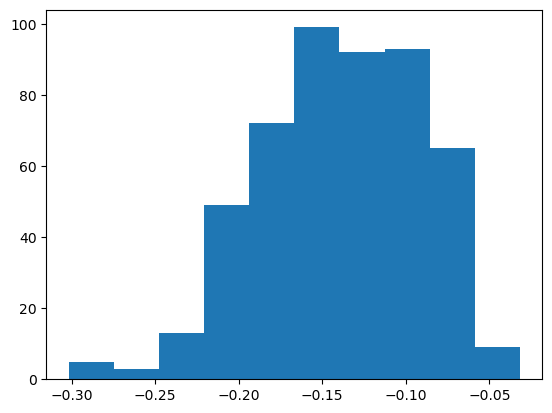

In [34]:
plt.hist(auroc_bootstrap, bins=10)

(array([  6.,  21.,  48.,  87., 111., 112.,  67.,  28.,  14.,   6.]),
 array([-0.06578759, -0.0260284 ,  0.01373078,  0.05348997,  0.09324916,
         0.13300835,  0.17276753,  0.21252672,  0.25228591,  0.2920451 ,
         0.33180429]),
 <BarContainer object of 10 artists>)

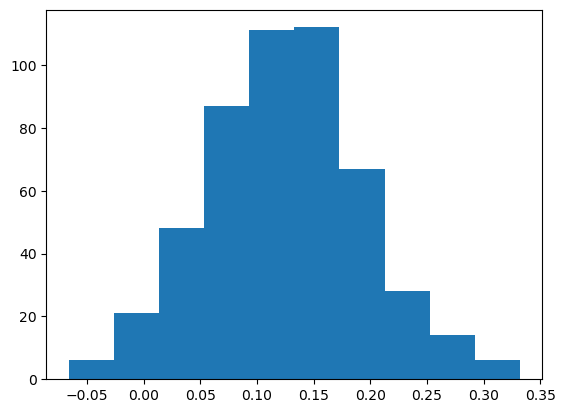

In [42]:
plt.hist(smr_bootstrap, bins=10)

In [63]:
print(f'95% confidence intervals for the AUROC difference is found between:\n\n{round(np.percentile(auroc_bootstrap, 2.5), 2)} and {round(np.percentile(auroc_bootstrap, 97.5), 2)}')

95% confidence intervals for the AUROC difference is found between:

-0.25 and -0.06


In [64]:
print(f'95% confidence intervals for the SMR difference is found between:\n\n{round(np.percentile(smr_bootstrap, 2.5), 2)} and {round(np.percentile(smr_bootstrap, 97.5), 2)}')

95% confidence intervals for the SMR difference is found between:

-0.01 and 0.27
